In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("activity_log.csv")

In [3]:
df.head()

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Number of Laps
0,Running,7/15/20 9:41,Cherry Hill Running,6.00,530,0:43:55,141,160,176,182,7:19,6:20,169,173,1.26,00:02.3,7
1,Running,7/14/20 17:45,Cherry Hill Running,6.50,587,0:47:04,144,160,172,182,7:14,6:35,183,187,1.29,03:32.7,7
2,Running,7/13/20 18:57,Cherry Hill Running,5.01,392,0:40:29,128,151,170,180,8:05,5:49,124,124,1.17,00:04.1,6
3,Running,7/12/20 18:44,Cherry Hill Running,7.01,633,0:52:55,142,157,172,180,7:33,5:00,215,219,1.24,00:05.1,8
4,Running,7/11/20 19:35,Cherry Hill Running,5.19,419,0:41:35,129,143,170,178,8:01,6:48,76,80,1.18,01:27.1,6


In [4]:
df.shape

(689, 17)

In [5]:
df.dtypes

Activity Type         object
Date                  object
Title                 object
Distance             float64
Calories              object
Time                  object
Avg HR                object
Max HR                object
Avg Run Cadence       object
Max Run Cadence       object
Avg Pace              object
Best Pace             object
Elev Gain             object
Elev Loss             object
Avg Stride Length    float64
Best Lap Time         object
Number of Laps         int64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Activity Type      689 non-null    object 
 1   Date               689 non-null    object 
 2   Title              689 non-null    object 
 3   Distance           689 non-null    float64
 4   Calories           689 non-null    object 
 5   Time               689 non-null    object 
 6   Avg HR             689 non-null    object 
 7   Max HR             689 non-null    object 
 8   Avg Run Cadence    689 non-null    object 
 9   Max Run Cadence    689 non-null    object 
 10  Avg Pace           689 non-null    object 
 11  Best Pace          689 non-null    object 
 12  Elev Gain          689 non-null    object 
 13  Elev Loss          689 non-null    object 
 14  Avg Stride Length  689 non-null    float64
 15  Best Lap Time      689 non-null    object 
 16  Number of Laps     689 non

In [7]:
df_copy = df.copy()

## 1. What is the average distance covered under 30 minutes? 

In [8]:
f'On average, {round(df.loc[df.Time < "0:30:00", "Distance"].mean(), 2)} miles are covered under 30 minutes by this runner.'

'On average, 2.14 miles are covered under 30 minutes by this runner.'

## 2. Analyzing average pace in different seasons

#### This is the first step of my quest to research the hypotheses of seasonality affecting running performance. 
In this first step, I am visualizing the average pace of this particular runner based on the different seasons.

In [9]:
def apply_seasons(month):
    if month in [3,4,5]:
        return "spring"
    elif month in [6,7,8]:
        return "summer"
    elif month in [9,10,11]:
        return "autumn"
    else:
        return "winter"

In [10]:
df["Season"] = df.Date.apply(lambda x: apply_seasons(int(x.split("/")[0])))

In [11]:
df.index[df["Avg Pace"].str.contains('--')].tolist()[0]

556

In [12]:
df.loc[df["Avg Pace"] == "--", "Avg Pace"] = '0'

replacing missing values with 0 --> this can lead to distortion in the results but there is only one missing value which is why I allowed myself to do this

In [13]:
df["Avg Pace"]

0      7:19
1      7:14
2      8:05
3      7:33
4      8:01
       ... 
684    6:59
685    7:02
686    7:34
687    7:20
688    7:21
Name: Avg Pace, Length: 689, dtype: object

converting the string in the "Avg Pace" column to integers in order to compute the mean for each season

In [14]:
df["Avg Pace Integer"] = df["Avg Pace"].apply(lambda x: int(float(x.replace(":", ""))))

In [15]:
df["Avg Pace Integer"]

0      719
1      714
2      805
3      733
4      801
      ... 
684    659
685    702
686    734
687    720
688    721
Name: Avg Pace Integer, Length: 689, dtype: int64

In [16]:
for season in df.Season.unique():
    print(f'{season} : {int(df.loc[df.Season == season, "Avg Pace Integer"].mean())}')

summer : 709
spring : 679
winter : 616
autumn : 628


Above we see that we can print the avg pace for each season. It remains to convert the integers into the proper format and assign them to the corresponding season in a dictionary. Finally, we visualize the results with matplotlib.

In [17]:
avg_pace_dict = dict()

In [18]:
for season in df.Season.unique():
    avg_pace_dict[season] = str(int(df.loc[df.Season == season, "Avg Pace Integer"].mean()))[:1] + ':' + \
                                str(int(df.loc[df.Season == season, "Avg Pace Integer"].mean()))[1:]

In [19]:
avg_pace_dict

{'summer': '7:09', 'spring': '6:79', 'winter': '6:16', 'autumn': '6:28'}

### As we can see there is a difference between the average pace per mile for the different seasons.
The biggest discrepency becomes evident when comparing **winter and summer**. This particular runner seems to need **1 MINUTE LONGER** to cover a mile in the summer compared to the winter season. This could be the result of warmer weather conditions in the summer slowing the runner down.

## 3. How many calories would this runner burn in a marathon? (Linear Regression)

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

In [21]:
df.columns

Index(['Activity Type', 'Date', 'Title', 'Distance', 'Calories', 'Time',
       'Avg HR', 'Max HR', 'Avg Run Cadence', 'Max Run Cadence', 'Avg Pace',
       'Best Pace', 'Elev Gain', 'Elev Loss', 'Avg Stride Length',
       'Best Lap Time', 'Number of Laps', 'Season', 'Avg Pace Integer'],
      dtype='object')

In [22]:
df.loc[df["Distance"] == "--", "Distance"] = '0'
df.loc[df["Calories"] == "--", "Calories"] = '0'

In [23]:
df['Calories'] = df['Calories'].apply(lambda x: x.replace(',', ''))

In [24]:
df['Calories'] = df['Calories'].astype('int')
df['Distance'] = df['Distance'].astype('int')

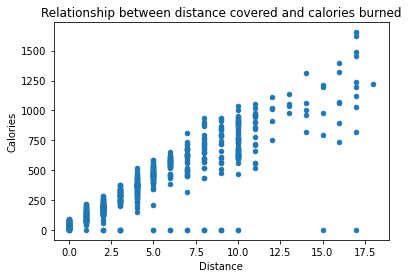

In [25]:
df.plot(kind='scatter', x='Distance', y='Calories')
plt.title("Relationship between distance covered and calories burned")
plt.show()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df.Distance, df.Calories, test_size=0.2)

In [27]:
linear_regression = LinearRegression()
linear_regression.fit(X_train.values.reshape(-1, 1), y_train.values)

LinearRegression()

In [28]:
prediction = linear_regression.predict(X_test.values.reshape(-1, 1))

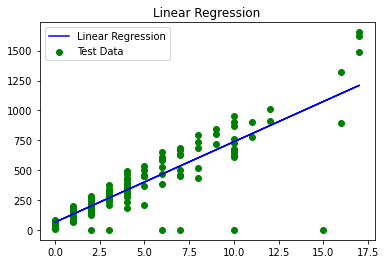

In [29]:
plt.plot(X_test, prediction, label="Linear Regression", color='b')
plt.scatter(X_test, y_test, label="Test Data", color='g')
plt.legend()
plt.title("Linear Regression")
plt.show()

In [31]:
# prediction of how many calories this runner would burn if he was to run a marathon
linear_regression.predict(np.array([[26.2]]))[0]

1829.994943647934

According to our model, the runnner would burn approximately 1830 calories if he was to run a marathon of 26.2 miles.

#### Scoring this model

In [35]:
linear_regression.score(X_test.values.reshape(-1,1), y_test.values)

0.7472938963182455

## 4. Does running in the morning affect run performance?

## 5. Predicting finish time for a marathon based on the available data